##Torque Rheometer data

#### Looping over data files and fitting parameters to torque and temp curve simultaneously with multistart

In [2]:
from datahandling import DataFile, alldatafiles, cuts, trim, file_parse
from lmfit import minimize, report_fit
from model_parameters import parameters, parameter_vectors, unpack_parameters, rand_ini_val
from curve_func_2 import torque_curve, fcn2min_torque, fcn2min, model_curves, joined_curves
from time import time as tm
from matplotlib.backends.backend_pdf import PdfPages
from directories import set_filename
% pylab inline

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


#### Loading all files

In [2]:
files = alldatafiles()
no_files = len(files)

#### Looping over files
Saving pdf of all torque, temp and species curves

Starting with fit
1
Starting with fit
2
Starting with fit
3
Starting with fit
4
Starting with fit
5
Completed Fit  1
__________________________
Starting with fit
1
Starting with fit
2
Starting with fit
3
Starting with fit
4
Starting with fit
5
Completed Fit  2
__________________________
Starting with fit
1
Starting with fit
2
Starting with fit
3
Starting with fit
4
Starting with fit
5
Completed Fit  3
__________________________
Starting with fit
1
Starting with fit
2
Starting with fit
3
Starting with fit
4
Starting with fit
5
Completed Fit  4
__________________________
Starting with fit
1
Starting with fit
2
Starting with fit
3
Starting with fit
4
Starting with fit
5
Completed Fit  5
__________________________
Starting with fit
1
Starting with fit
2
Starting with fit
3
Starting with fit
4
Starting with fit
5
Completed Fit  6
__________________________
Starting with fit
1
Starting with fit
2
Starting with fit
3
Starting with fit
4
Starting with fit
5
Completed Fit  7
___________________

C:\Anaconda\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


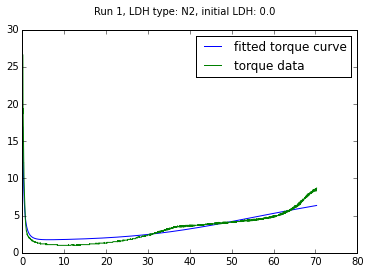

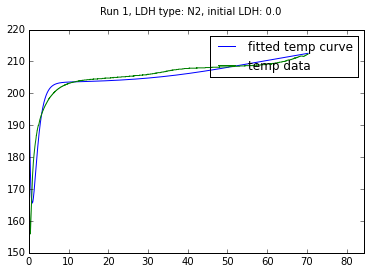

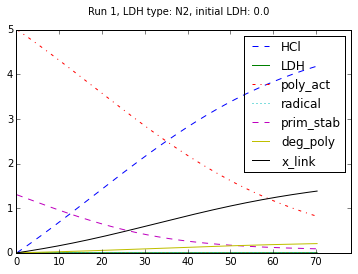

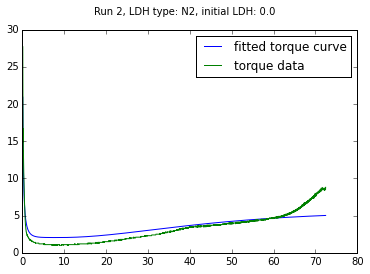

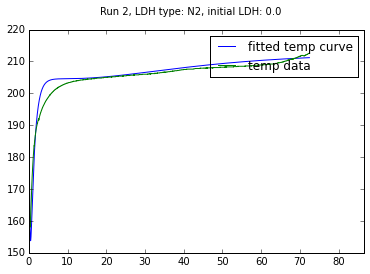

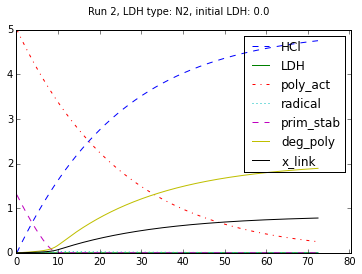

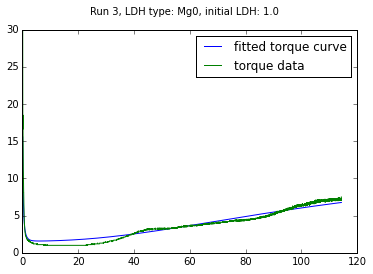

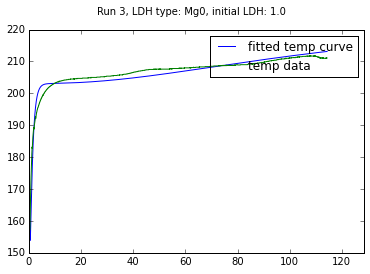

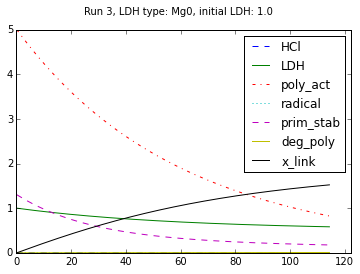

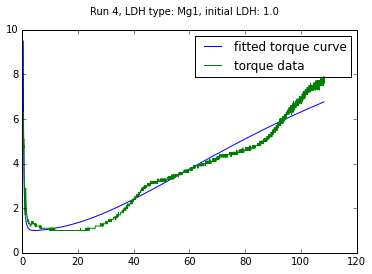

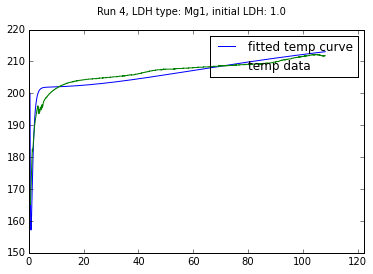

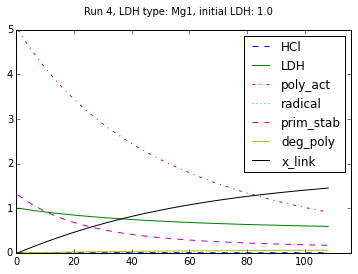

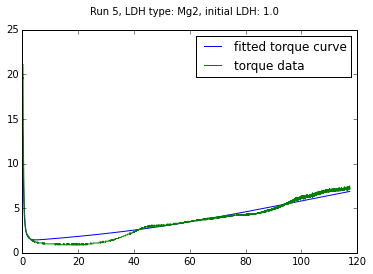

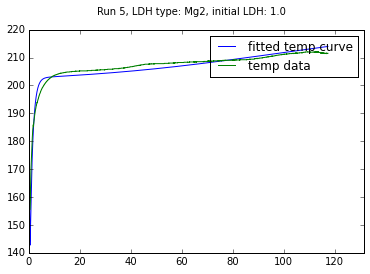

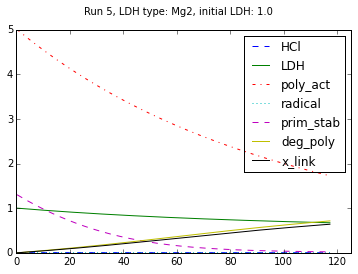

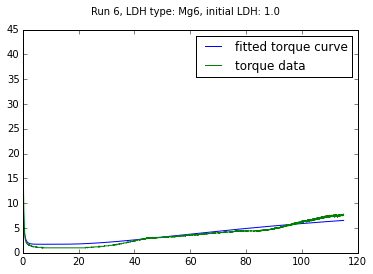

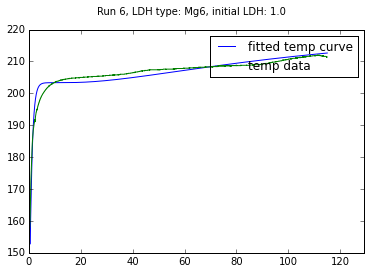

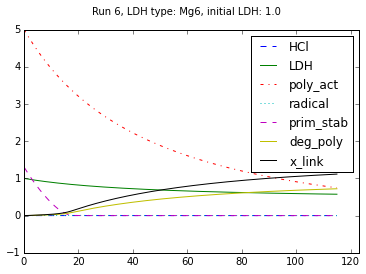

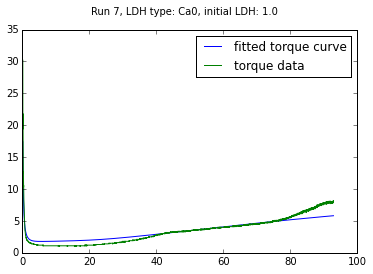

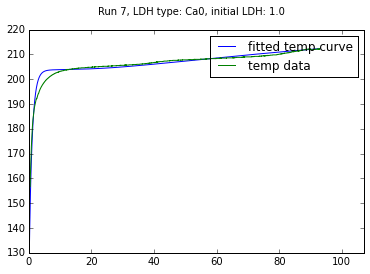

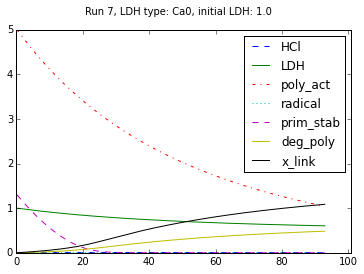

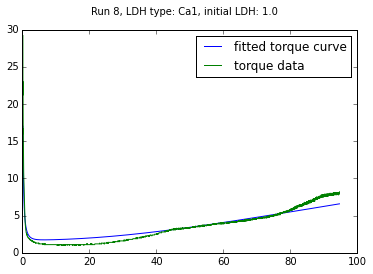

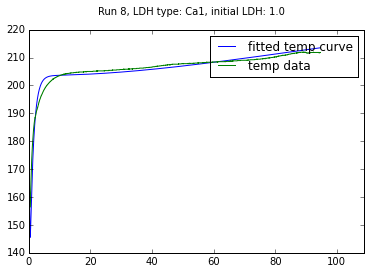

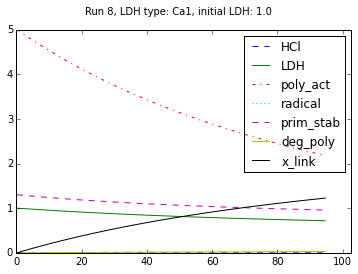

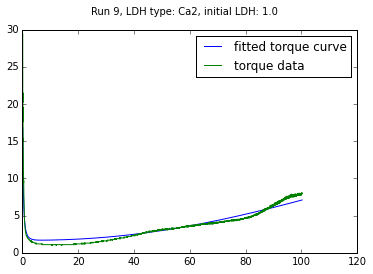

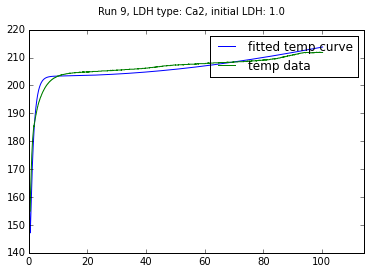

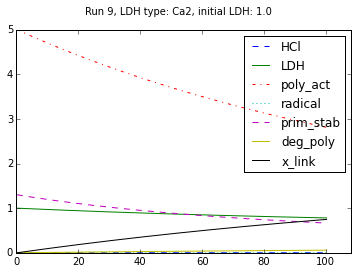

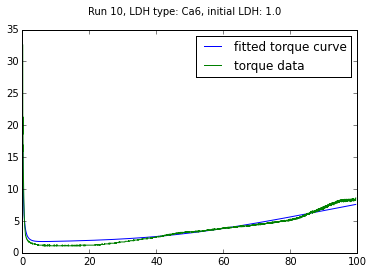

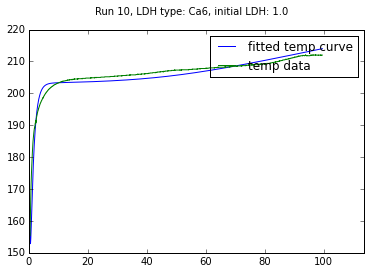

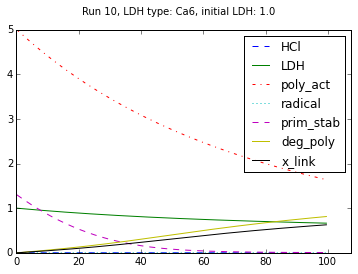

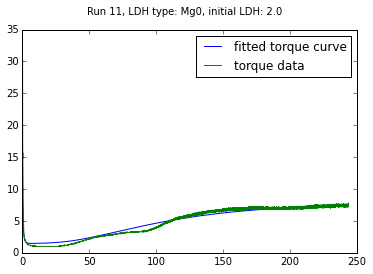

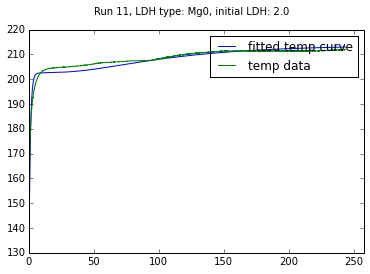

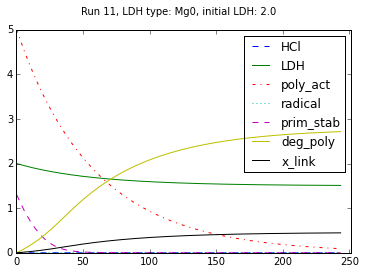

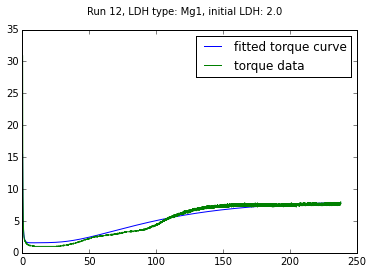

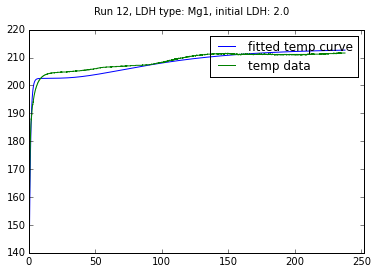

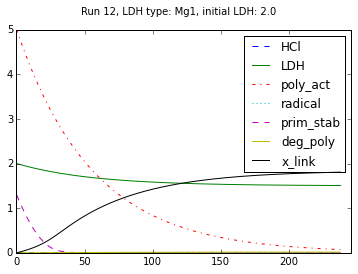

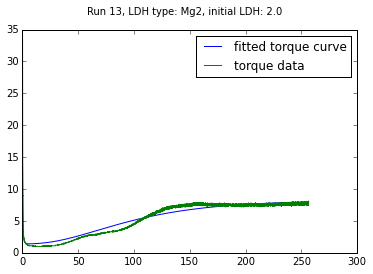

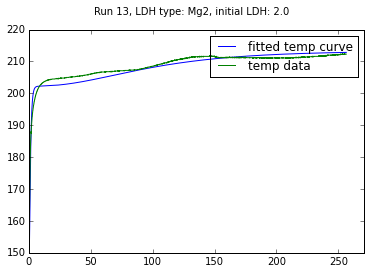

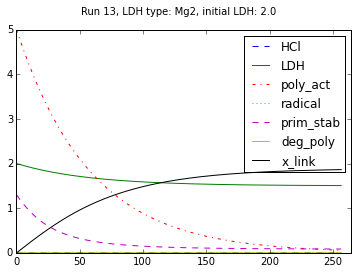

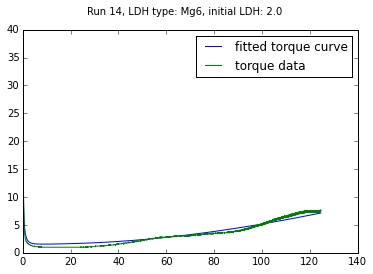

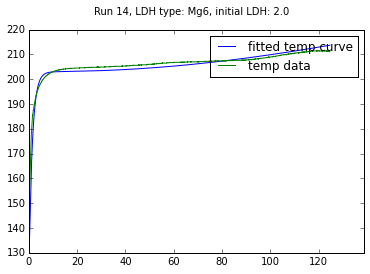

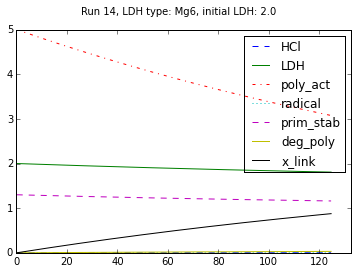

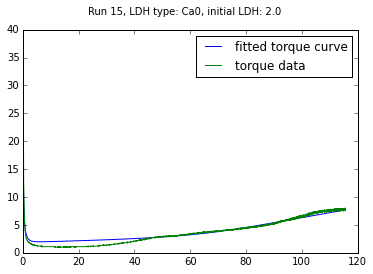

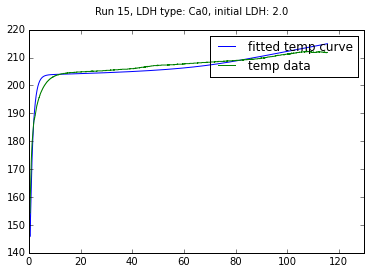

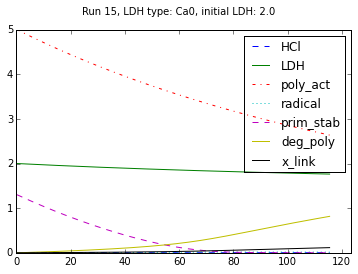

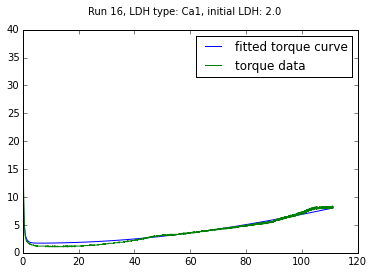

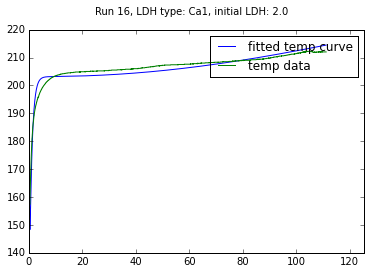

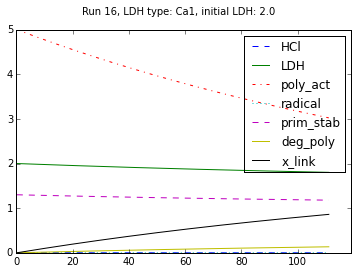

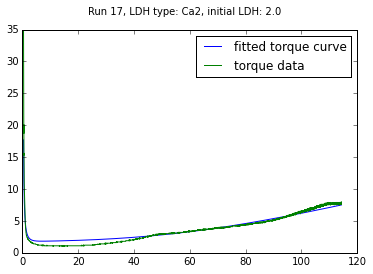

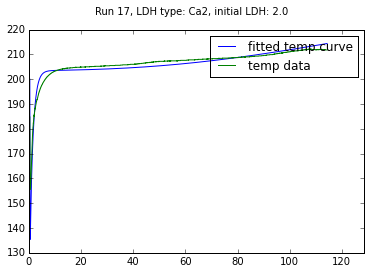

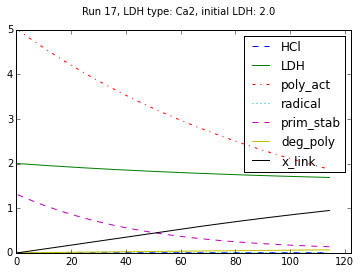

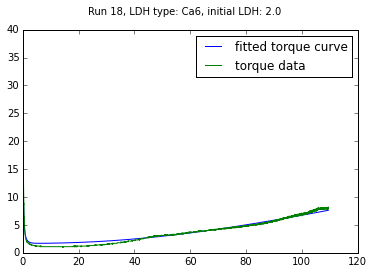

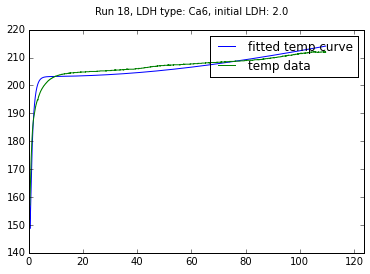

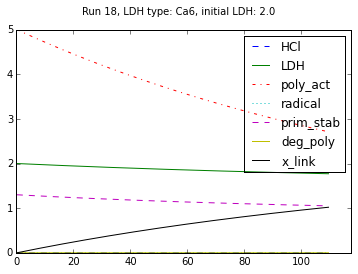

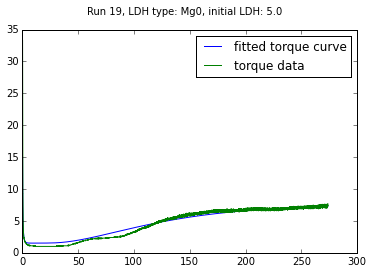

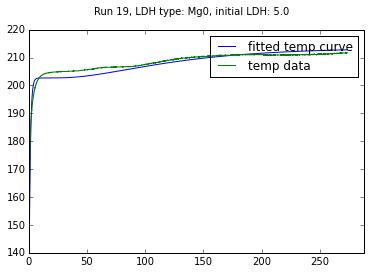

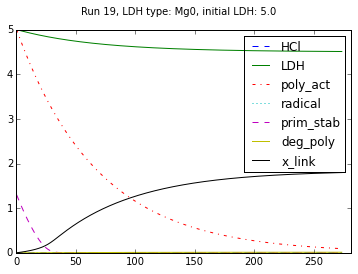

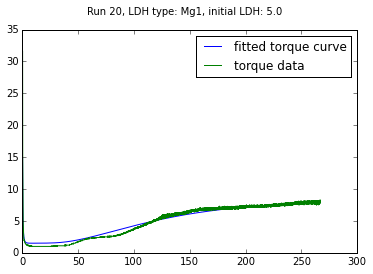

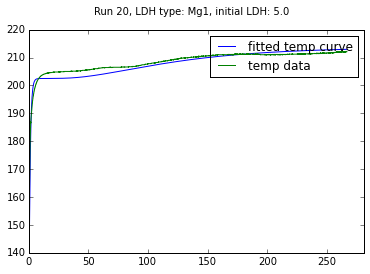

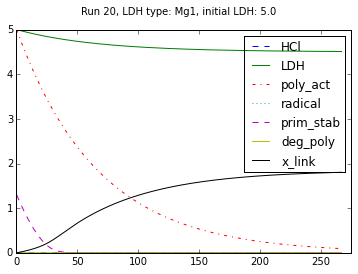

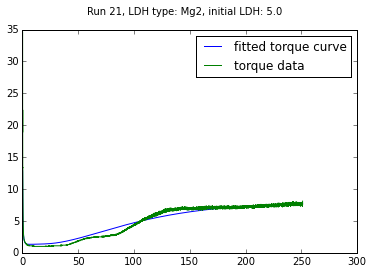

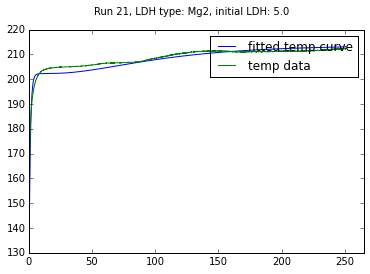

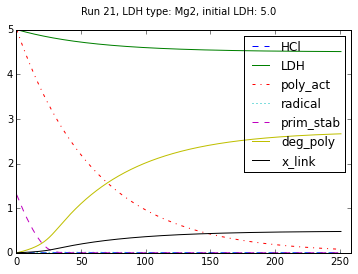

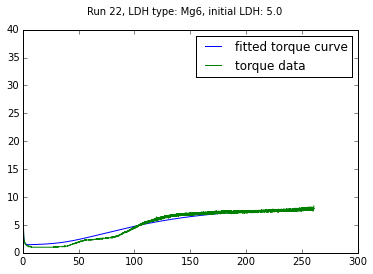

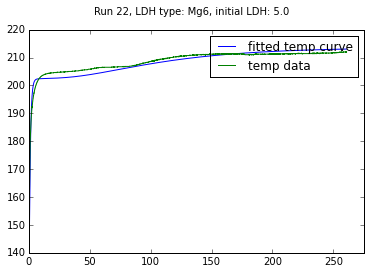

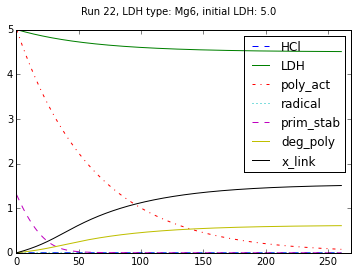

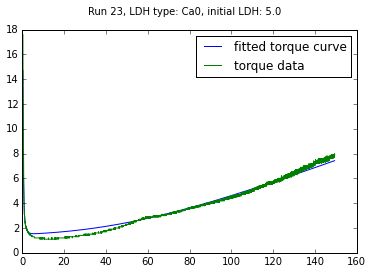

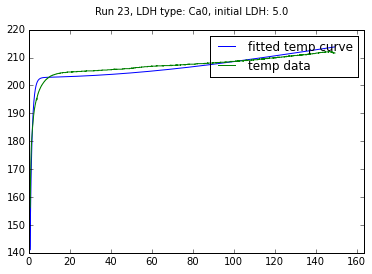

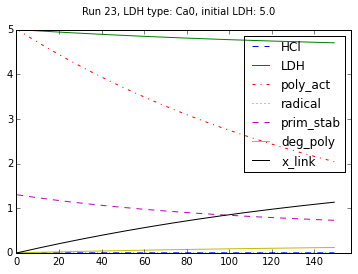

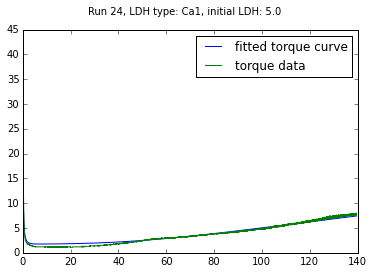

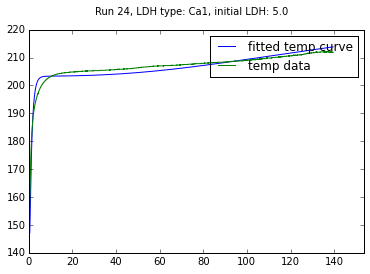

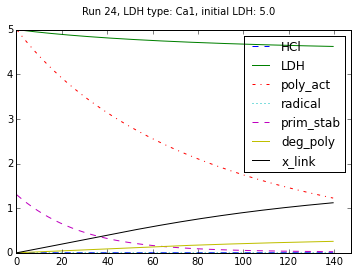

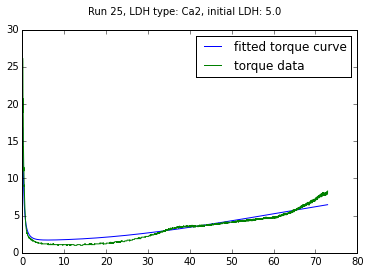

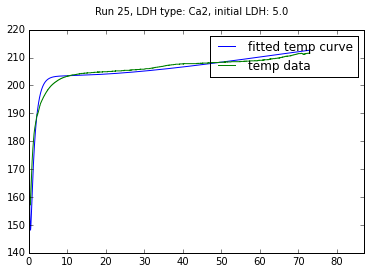

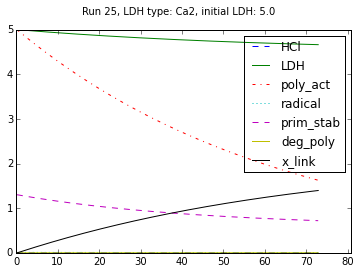

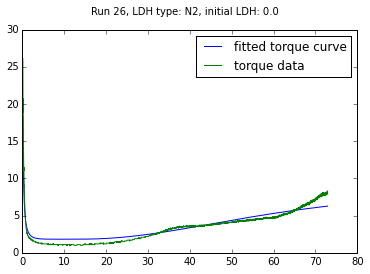

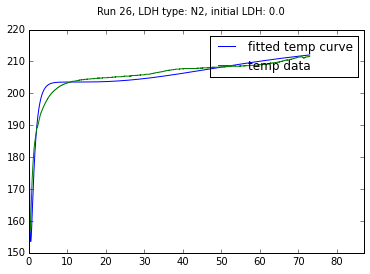

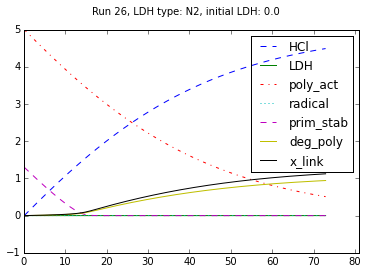

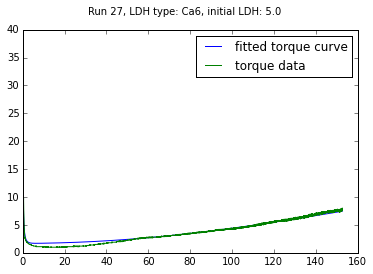

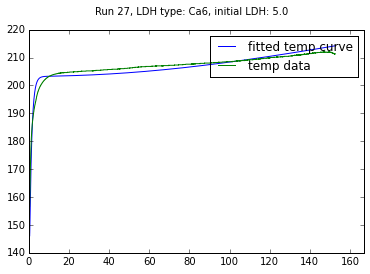

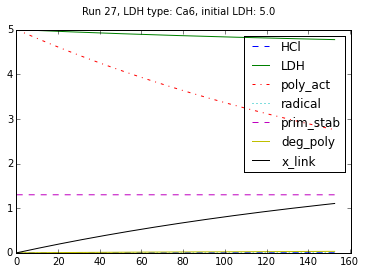

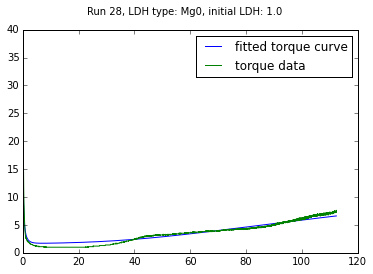

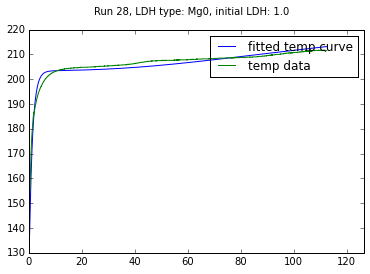

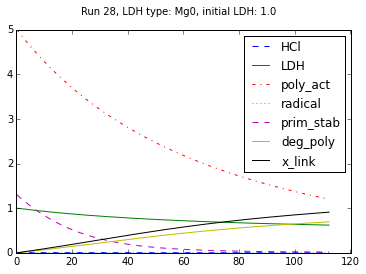

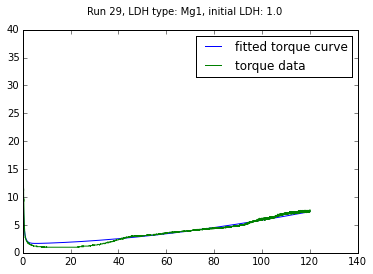

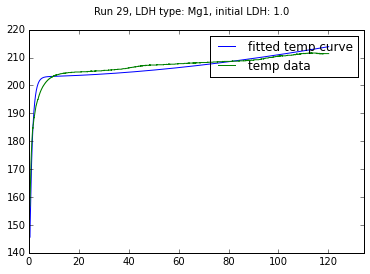

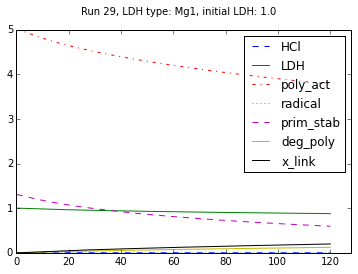

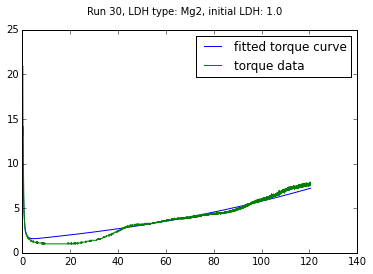

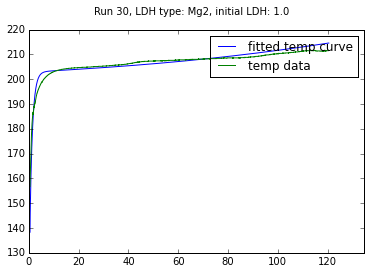

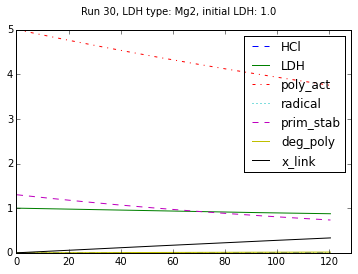

In [3]:
fname = set_filename('Reinhard Fit/all_curves.pdf')


t = tm()
all_ps = []
all_LDH_type = []
all_errors = []
all_int_errors = []
with PdfPages(fname) as pdf:

    for i, f in enumerate(files):
        time_data, temp_data, torque_data = DataFile(f).simple_data()

        # Trimming data
        c = cuts(torque_data)
        time_data = trim(time_data, c)
        temp_data = trim(temp_data, c)
        torque_data = trim(torque_data, c)
            
        #Joining data
        joined_data = joined_curves(torque_data, temp_data)

        # Parsing filenames
        LDH_0, LDH_type = file_parse(f)
        all_LDH_type = append(all_LDH_type, LDH_type)
        
        # Multistart
        starts = 5
        smallest_error = 100000.0
        
        for j in range(starts):
            print 'Starting with fit'
            # Initialising values
            ini_val = rand_ini_val(LDH_0)
            
            # Initialising and limiting parameters
            p = parameters(ini_val)

            # Fitting data
            result = minimize(fcn2min, p, args=(time_data, joined_data))
            
            # Calculating average and integral of absolute error
            error_list = fcn2min(p, time_data, joined_data)
            abs_error_list = map(abs, error_list)
            ave_abs_error = sum(abs_error_list)/len(error_list)
            torque_error_list = fcn2min_torque(p, time_data, torque_data)
            abs_torque_error_list = map(abs, torque_error_list)
            int_abs_error = trapz(abs_torque_error_list, dx=0.017)
            
            # Check error and save parameters
            smallest_error = min([smallest_error, ave_abs_error])
            if smallest_error == ave_abs_error:
                p_best = p
                smallest_int_error = int_abs_error
            
            print j + 1
            
        #Storing parameter and error values
        all_ps.append(p_best)
        all_errors.append(smallest_error)
        all_int_errors.append(smallest_int_error)
        
        print 'Completed Fit ',(i + 1)
        print '__________________________'
        
        #Plotting to pdf
        curves = model_curves(p_best, time_data)
        HCl, LDH, poly_act, radical, prim_stab, deg_poly, x_link, T, Tm, mu, torque = curves
        
        title = 'Run ' + str(i + 1) + ', LDH type: ' + LDH_type + ', initial LDH: ' + str(LDH_0)
        
        fig_torque = figure()
        fig_torque.suptitle(title)
        plot(time_data, torque, label='fitted torque curve')
        plot(time_data, torque_data, label='torque data')
        legend()
        
        fig_temp = figure()
        fig_temp.suptitle(title)
        plot(time_data, Tm, label='fitted temp curve')
        plot(time_data, temp_data, label='temp data')
        legend()
        xlim([0, time_data[len(time_data) - 1] + 14])
        
        fig_species = figure()
        fig_species.suptitle(title)
        plot(time_data, HCl, '--', label='HCl')
        plot(time_data, LDH, label='LDH')
        plot(time_data, poly_act, '-.', label='poly_act')
        plot(time_data, radical, ':', label='radical')
        plot(time_data, prim_stab, '--', label='prim_stab')
        plot(time_data, deg_poly, label='deg_poly')
        plot(time_data, x_link, label='x_link')
        legend()
        xlim([0, time_data[len(time_data) - 1] + 8])
        
        pdf.savefig(fig_torque)
        pdf.savefig(fig_temp)
        pdf.savefig(fig_species)

elapsed = tm() - t
print '*******************'
print 'elapsed time (min) =', elapsed/60.

#### Generating parameter vectors and plotting

In [4]:
para_V = parameter_vectors(all_ps)

In [5]:
figure_headings = ['k1, visc-torque',
                   'k2, Tm-T',
                   'k3, LDH rxn',
                   'k4, auto-catalytic HCl production rxn',
                   'k5, initiation rxn for HCl production',
                   'k6, primary stabiliser rxn',
                   'k7, radical to degraded polymer',
                   'k8, radical to cross-link',
                   'k9, degraded polymer effect on visc',
                   'k10, cross-linking effect on visc',
                   'k11, mechanical work affecting temp',
                   'UA',
                   'mu_0',
                   'E',
                   'q',
                   'prim_stab_0',
                   'LDH_0']

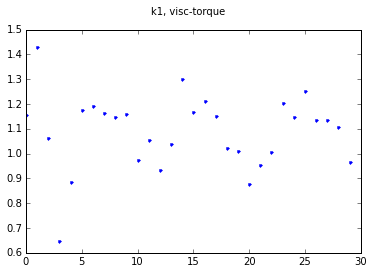

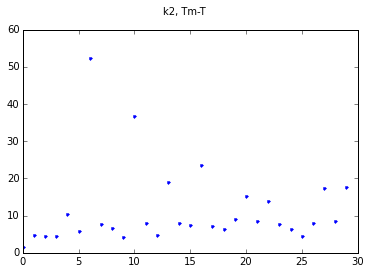

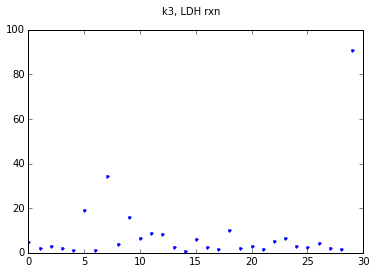

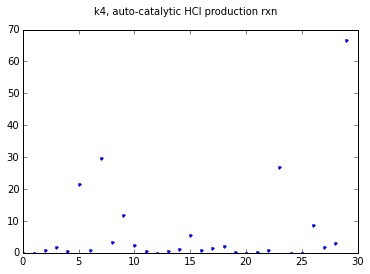

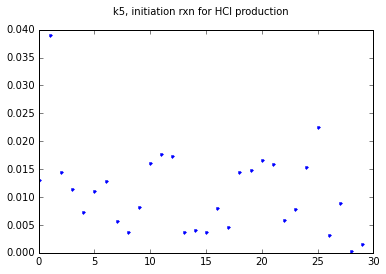

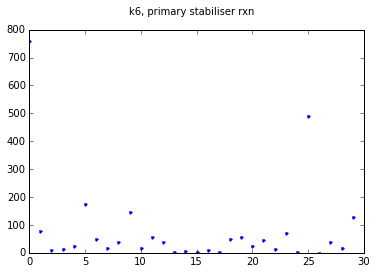

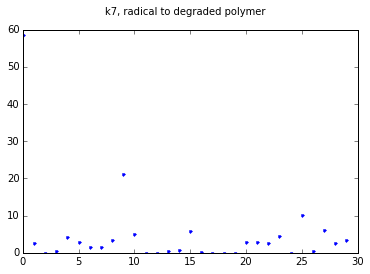

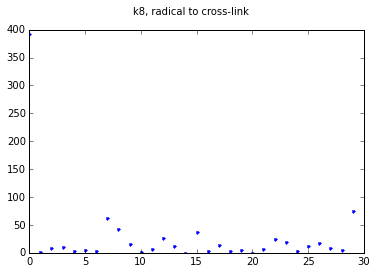

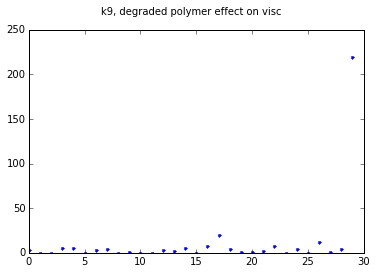

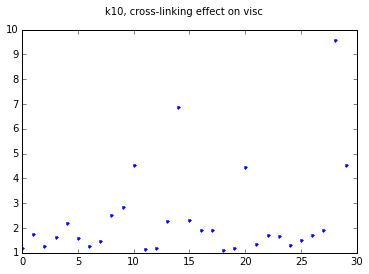

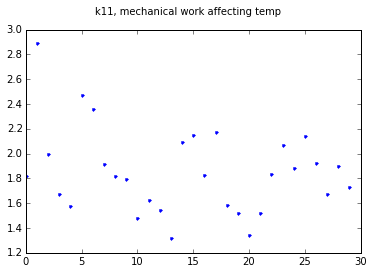

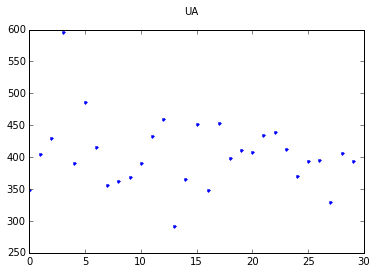

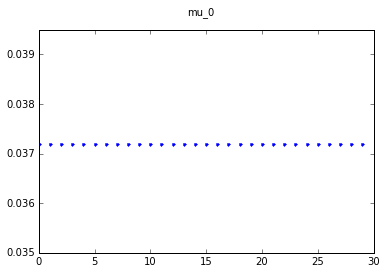

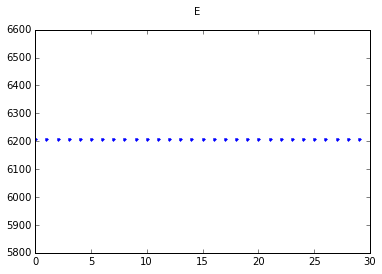

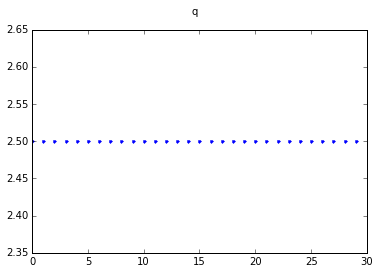

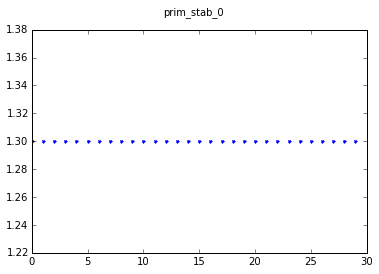

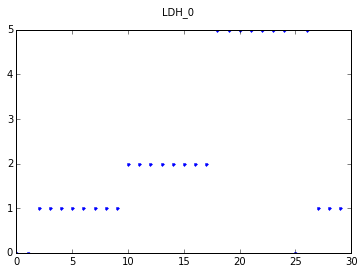

In [6]:
for h, ps in zip(figure_headings, para_V):
    figure().suptitle(h)
    plot(ps, '.')

####Placing parameters into DataFrame

In [7]:
from pandas import DataFrame

In [8]:
para_frame = DataFrame.from_records(para_V, index=figure_headings).transpose()

Mean values of each parameter

In [9]:
para_frame.mean(axis=0)

k1, visc-torque                             1.089213
k2, Tm-T                                   11.363197
k3, LDH rxn                                 8.638571
k4, auto-catalytic HCl production rxn       6.490424
k5, initiation rxn for HCl production       0.011005
k6, primary stabiliser rxn                 79.465840
k7, radical to degraded polymer             4.812639
k8, radical to cross-link                  27.628729
k9, degraded polymer effect on visc        10.526970
k10, cross-linking effect on visc           2.404321
k11, mechanical work affecting temp         1.855898
UA                                        405.033299
mu_0                                        0.037200
E                                        6208.600000
q                                           2.500000
prim_stab_0                                 1.300000
LDH_0                                       2.233333
dtype: float64

Upper boundary values for each parameter = mean + 2.standard deviation

In [10]:
upper_bounds = para_frame.mean(axis=0) + 2*para_frame.std(axis=0)
upper_bounds

k1, visc-torque                             1.386085
k2, Tm-T                                   32.416489
k3, LDH rxn                                42.626421
k4, auto-catalytic HCl production rxn      34.270604
k5, initiation rxn for HCl production       0.026622
k6, primary stabiliser rxn                396.255531
k7, radical to degraded polymer            26.735156
k8, radical to cross-link                 170.004813
k9, degraded polymer effect on visc        90.064460
k10, cross-linking effect on visc           6.176198
k11, mechanical work affecting temp         2.541368
UA                                        515.438890
mu_0                                        0.037200
E                                        6208.600256
q                                           2.500000
prim_stab_0                                 1.300000
LDH_0                                       5.821949
dtype: float64

In [11]:
lower_bounds = para_frame.mean(axis=0) - 2*para_frame.std(axis=0)
lower_bounds

k1, visc-torque                             0.792340
k2, Tm-T                                   -9.690096
k3, LDH rxn                               -25.349280
k4, auto-catalytic HCl production rxn     -21.289755
k5, initiation rxn for HCl production      -0.004613
k6, primary stabiliser rxn               -237.323852
k7, radical to degraded polymer           -17.109877
k8, radical to cross-link                -114.747356
k9, degraded polymer effect on visc       -69.010520
k10, cross-linking effect on visc          -1.367555
k11, mechanical work affecting temp         1.170427
UA                                        294.627709
mu_0                                        0.037200
E                                        6208.599744
q                                           2.500000
prim_stab_0                                 1.300000
LDH_0                                      -1.355282
dtype: float64

Adding columns for LDH type and Average Absolute Error to DataFrame. 
-Note: the Ave Abs Error is the error on the joined curve with the number ranges equated

In [12]:
para_frame['LDH type'] = all_LDH_type
para_frame['Average of Absolute Error'] = all_errors
para_frame['Integral of the Absolute Error'] = all_int_errors

Writing DataFrame to csv

In [1]:
fname = set_filename('Reinhard Fit/all_parameters.csv')
para_frame.to_csv(fname)

NameError: name 'set_filename' is not defined

##Metrastat model

####Generate file names of YI-data and load initial conditions

In [1]:
from data_refine import get_file_names
from parameters import get_initial, get_constants

# get file names
exp_data = get_file_names('Wimpie Data/Rheomix Results/', sample='Mg')

# load initial conditions
all_initial = get_initial('Reinhard Fit/')

# load rate constants
all_constants = get_constants('Reinhard Fit/')

####Determine least-squares solution of YI-data

In [2]:
from model_func import metrastat_model

parameters, errors, quadratic, all_times, all_YI = metrastat_model(exp_data, all_initial, all_constants,
                                                                  refine_extended=False, one_set_params=True)

Combination 1/1001
error: 2317949.520326
elapsed time = 0.158867 min
time remaining = 158.866668 min
Combination 2/1001
Combination 3/1001
Combination 4/1001
Combination 5/1001
Combination 6/1001
Combination 7/1001
Combination 8/1001
Combination 9/1001
Combination 10/1001
Combination 11/1001
Combination 12/1001
Combination 13/1001
Combination 14/1001
Combination 15/1001
Combination 16/1001
Combination 17/1001
Combination 18/1001
Combination 19/1001
Combination 20/1001
error: 2305872.707255
elapsed time = 3.300783 min
time remaining = 161.903423 min
Combination 21/1001
Combination 22/1001
Combination 23/1001
Combination 24/1001
Combination 25/1001
Combination 26/1001
Combination 27/1001
Combination 28/1001
Combination 29/1001
Combination 30/1001
Combination 31/1001
Combination 32/1001
Combination 33/1001
Combination 34/1001
Combination 35/1001
Combination 36/1001
Combination 37/1001
Combination 38/1001
Combination 39/1001
Combination 40/1001
Combination 41/1001
Combination 42/1001
Combi

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
print parameters

OrderedDict([('a', 23.173257531537597), ('b', 16.494169524161279), ('c', 56.345676707876031), ('d', 45.897066640915497), ('k12', 0)])


####Plot each graph

In [4]:
from matplotlib.backends.backend_pdf import PdfPages
from numpy import array, ones
from Metrastat import metrastat
from scipy.integrate import odeint
from matplotlib import pyplot as plt
from directories import set_filename

fname = set_filename('Fitting results/21 May Mg fits known offset.pdf')

# test for one set params
if len(parameters) == 5:
    from copy import copy
    
    param_list = []
    param_copy = copy(parameters)
    
    error_list = []
    error_copy = copy(errors)
    
    quad_list = []
    quad_copy = copy(quadratic)
    
    for i in range(len(exp_data)):
        param_list.append(param_copy)
        error_list.append(error_copy)
        quad_list.append(quad_copy)
    
    parameters = param_list
    errors = error_list
    quadratic = quad_list

with PdfPages(fname) as pdf:
    for i, params in enumerate(parameters):
        # unpack the experimental data
        time = all_times[i]
        YI = all_YI[i]
        initial = all_initial[i]
        constants = all_constants[i]
        data = exp_data[i]
        
        # generate the curve with fitted coefficients
        a = params['a']
        b = params['b']
        c = params['c']
        d = params['d']
#        e = params['e']
        k12 = params['k12']

        quad = quadratic[i]
        
        conc = odeint(metrastat, initial, time, args=(k12, constants))
        conc_mat = array(conc, dtype=float)

        # build an array in which each specie correlates to an index
        LDH = conc_mat[:, 1]
        poly_active = conc_mat[:, 2]
        deg_poly = conc_mat[:, 5]
        cross_link = conc_mat[:, 6]
        specie_mat = array([LDH, poly_active,
                            deg_poly, cross_link], dtype=float)

        # build an array which will contain the species for each coefficient
        func_array = array([ones(len(YI)),                 # LDH
                            ones(len(YI)),                 # poly_active
                            ones(len(YI)),                 # poly_deg
                            ones(len(YI))], dtype=float)   # cross_link

        # apply the coeffs in the powers list
        for i, coeffs in enumerate(quad):
            for specie_power in coeffs:
                func_array[i] *= specie_mat[specie_power]

        fit = a*func_array[0] + \
              b*func_array[1] + \
              c*func_array[2] + \
              d*func_array[3] + \
              YI[0]
        
        # plot YI using the result of the least-squares fit
        fig = plt.figure()
        path, fname = data.rsplit('/', 1)
        sample_name, ftype = fname.split('.')

        plt.title('Fit for sample ' + sample_name)
        plt.xlabel('Time /s')
        plt.ylabel('YI')
        plt.plot(time, YI,
                 time, fit)
        plt.legend(['Experimental', 'Fit'], loc=0)

        # save plot
        fname_image = set_filename('Fitting results/' + sample_name + '.png')
        plt.savefig(fname_image)
        pdf.savefig()
        plt.close()
        
        

####Save results to csv file

In [5]:
import pandas as pd

# save the fitting results of each curve in a list
results_df = []

for i in range(len(parameters)):
    # create a dictionary with the fitting results
    param_dict = pd.Series(parameters[i])
    add_dict = pd.Series({"error": errors[i],
                          "quadratic function": quadratic[i]})
    final_dict = param_dict.append(add_dict)

    # add the dictionary to the final list
    results_df.append(final_dict)

# save the fitting results to a .csv database
results_df = pd.DataFrame(results_df)
fname = set_filename('Fitting results/21 May Mg fits known offset.csv')
pd.DataFrame.to_csv(results_df, fname)